# Predicción y Clasificación en la Industria Azucarera: Análisis Predictivo en Ingenio La Providencia
\\
## Eduardo José Avendaño Caicedo
## Sebastián Dow Valenzuela
\\
## Maestría en Ciencia de Datos
## Análisis Cuantitativo
## PhD. Milton Sarria-Paja
\\
## Marzo de 2024
## Universidad Icesi
\\
**Descripción del Proyecto:** En este análisis trabajamos con datos del cultivo de caña de azúcar del Ingenio La Providencia (Valle del Cauca, Colombia). Se utilizan dos conjuntos de datos reales: **HISTORICO_SUERTES.xlsx** (datos históricos de producción por lote, para un modelo de regresión) y **BD_IPSA_1940.xlsx** (datos agronómicos detallados, para un modelo de clasificación). El objetivo es construir un Jupyter Notebook completo que abarque limpieza de datos, análisis exploratorio, modelado predictivo y evaluación de resultados, tanto para regresión (predicción de rendimiento) como para clasificación (categorizar rendimiento y calidad en niveles alto/medio/bajo).


Este notebook aborda el análisis predictivo y la clasificación aplicada al contexto del **Ingenio La Providencia**. Se usan dos datasets:

- **HISTORICO_SUERTES.xlsx**: Datos históricos para predecir dos variables clave:
  - **TCH**: Toneladas de caña por hectárea (rendimiento).
  - **%Sac.Caña**: Porcentaje de sacarosa en la caña (calidad).

- **BD_IPSA_1940.xlsx**: Datos detallados para clasificar los registros en niveles de desempeño (alto, medio, bajo) tanto para TCH como para %Sac.Caña.

Se desarrollan modelos de regresión lineal (con diagnóstico de supuestos y validación cruzada) y modelos de clasificación (KNN y regresión logística con regularización L1 y L2) utilizando validación cruzada estratificada.

Las librerías empleadas son: **numpy**, **pandas**, **matplotlib**, **seaborn** y los módulos de **scikit-learn** necesarios para modelado, validación y métricas de desempeño.

In [ ]:
# Importación de bibliotecas
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

%matplotlib inline

sns.set(style='whitegrid')

## Parte 1: Modelo de Regresión (Predicción de Rendimiento)

A continuación se describe el proceso de carga, exploración, limpieza y análisis del conjunto de datos históricos (`HISTORICO_SUERTES.xlsx`) para desarrollar modelos de regresión orientados a predecir el rendimiento y la calidad de la caña de azúcar.

### 1.1 Carga de Datos y Exploración Inicial

In [ ]:
# Cargar datos históricos de producción (se asume que la información se encuentra en la primera hoja)
df_hist = pd.read_excel('HISTORICO_SUERTES.xlsx', sheet_name=0)

# Mostrar las dimensiones del dataset
print(f"Dimensiones del dataset: {df_hist.shape}")

# Visualizar las primeras 5 filas
display(df_hist.head(5))

Dimensiones del dataset: (21027, 85)


,Período,Hacienda,Nombre,Zona,Tenencia,Suerte,Suelo,Area Neta,Dist Km,Variedad,...,Humedad Rel Media Ciclo,Oscilacion Temp Med 0-3,Oscilacion Temp Ciclo,Sum Oscilacion Temp Ciclo,Radicion Solar 0-3,Radiacion Solar Ciclo,Precipitacion 0_3,Precipitacion Ciclo,Evaporacion 0-3,Evaporacion Ciclo
0,201701,80493,LA CONCHA,IP02,51.0,002A,CANTARINA,6.00,4.3,CC85-92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201701,81284,UKRANIA INCAUCA,IP05,81.0,039B,NaN,1.45,NaN,CC85-92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201701,80203,EL AMPARO SAA,IP05,31.0,007,CORINTIAS,8.24,23.0,CC01-1228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,201701,81380,SAN JUDAS INCAUCA,IP05,82.0,013A,NaN,1.05,66.5,CC01-1940,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,201701,80298,JAVA,IP06,31.0,025A,GALPON,4.53,17.0,RB73-2223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* **Dimensiones:** El dataset histórico contiene más de 21.000 registros (filas) y 85 columnas (variables). Cada fila representa un lote de caña en un periodo determinado (año/mes).
* **Variables principales:** Incluye identificadores de Hacienda, Lote (Suerte), características del suelo y cultivo, fechas (siembra, corte, riego), insumos aplicados, clima, y variables de rendimiento. Por ejemplo, **TCH** (Toneladas de Caña por Hectárea) es un indicador clave de rendimiento, y **%Sac.Caña** representa el porcentaje de sacarosa (azúcar) en la caña, reflejando calidad del cultivo.

In [ ]:
# Inspeccionar nombres de columnas relevantes
display(df_hist.columns.tolist())

# Obtener estadísticas descriptivas de las variables de interés
display(df_hist[['TCH', '%Sac.Caña']].describe())

['Período',
 'Hacienda',
 'Nombre',
 'Zona',
 'Tenencia',
 'Suerte',
 'Suelo',
 'Area Neta',
 'Dist Km',
 'Variedad',
 'Cod.Estado #',
 'Cod.Estado',
 'F.Siembra',
 'D.S.',
 'Ult.Riego',
 'Edad Ult Cos',
 'F.Ult.Corte',
 'Destino 1=Semilla',
 'Cod. T.Cultivo',
 'Cultivo',
 'Fec.Madur.',
 'Producto',
 'Dosis Madurante',
 'Semanas mad.',
 'TonUltCorte',
 'TCH',
 'TCHM',
 'Ton.Azucar',
 'Rdto',
 'TAH',
 'TAHM',
 'Sac.Caña Precosecha',
 'Edad.Precosecha',
 '%Sac.Caña',
 '%Sac.Muestreadora',
 '%ATR',
 'KATRHM',
 '%Fibra Caña',
 '%AR Jugo',
 '%ME Min',
 '%ME Veg',
 '%ME Tot',
 'Brix',
 'Pureza',
 'Vejez',
 'Tipo Quema',
 'T.Corte',
 'Cerca de',
 'Cosechó',
 'Num.Riegos',
 'M3 Riego',
 'DDUlt.Riego',
 'Lluvias (2 Meses Ant.)',
 'Lluvias Ciclo',
 'Lluvias 0 -3',
 'Lluvias tres a seis',
 'Lluvias seis a nueve',
 'Luvias 9 -FC',
 '%Infest.Diatrea',
 'Fosfato Jugo',
 'Fert.Nitrogen.',
 'Urea 46%',
 'MEZ',
 'Boro Granul.',
 'MicroZinc',
 'NITO_XTEND',
 'Sul.Amonio',
 'NITRAX-S',
 'Vinaza',
 'Codig

,TCH,%Sac.Caña
count,21027.000000,20578.000000
mean,129.608509,12.320202
std,32.846029,1.145738
min,1.573653,7.086000
25%,108.691426,11.619000
50%,129.479600,12.370650
75%,150.407607,13.087500
max,401.045947,18.400000


- **TCH (ton/ha):** Rango típico ~50 a 150 ton/ha, con algunos valores más altos. Un vistazo a `describe()` indica media y desviación estándar, y posibles valores máximos atípicos.
- **%Sac.Caña:** Porcentaje de sacarosa en caña, normalmente ~10-15%. Valores fuera de este rango serían inusuales.

### 1.2 Limpieza de Datos y Preparación

En esta etapa se identifican y gestionan valores nulos, outliers y se realizan transformaciones para optimizar el conjunto de datos para el modelado.

**Detección de valores nulos:** Se calcula el porcentaje de nulos por columna. Las variables con >50% de nulos (por ejemplo, algunas columnas climáticas) pueden descartarse, mientras que aquellas con pocos nulos se imputan con la media, mediana o un valor específico.

In [ ]:
# Calcular el porcentaje de valores nulos por columna
null_pct = df_hist.isnull().mean() * 100
display(null_pct.sort_values(ascending=False).head(20))

,0
Sum Oscilacion Temp Ciclo,100.000000
Fert.Nitrogen.,100.000000
Urea 46%,96.561564
NITRAX-S,96.442669
MEZ,95.382128
MicroZinc,94.535597
Boro Granul.,93.888810
Sul.Amonio,93.546393
NITO_XTEND,82.503448
Vinaza,80.510772


- Para variables con **muchos nulos** (p.ej. algunas columnas climáticas o de insumos con >50% de nulos), decidimos si eliminarlas o imputar valores. En este caso, las columnas de clima como *Precipitación* o *Radiación* tienen aprox. 78% de nulos, por lo que podrían descartarse del modelo (no aportan suficiente información fiable). Variables con pocos nulos (~1-5%) se pueden **imputar** con valores razonables (media/mediana) o marcar como "Desconocido" si son categóricas.

**Ejemplo:** Imputamos la columna *Dosis Madurante* (dosis de madurador aplicada) con 0 cuando está vacía (asumiendo que nulo = no se aplicó madurador):

In [ ]:
# Imputar nulos en 'Dosis Madurante' con 0
df_hist['Dosis Madurante'].fillna(0, inplace=True)

<ipython-input-52-8814cd401ed0>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_hist['Dosis Madurante'].fillna(0, inplace=True)


### 1.3 Detección de Outliers

Utilizamos diagramas de caja (*boxplots*) y estadísticas para detectar outliers en las variables numéricas clave. Por ejemplo, en **TCH** identificamos valores inusualmente altos:


In [ ]:
# Cálculo del percentil 99 para TCH
p99 = np.percentile(df_hist['TCH'].dropna(), 99)
print(f"Percentil 99 de TCH: {p99}")
print(f"Valor máximo de TCH: {df_hist['TCH'].max()}")

# Identificar outliers en TCH
outliers = df_hist[df_hist['TCH'] > 3 * df_hist['TCH'].std()]
display(outliers[['Hacienda', 'Nombre', 'TCH']])

Percentil 99 de TCH: 210.73062272000004
Valor máximo de TCH: 401.045947


,Hacienda,Nombre,TCH
0,80493,LA CONCHA,121.198333
2,80203,EL AMPARO SAA,174.347087
3,81380,SAN JUDAS INCAUCA,136.790476
4,80298,JAVA,113.068432
5,80328,LA ROCHELA,163.072307
...,...,...,...
21022,80102,LA PAZ,172.446666
21023,80102,LA PAZ,108.573770
21024,80102,LA PAZ,145.808108
21025,80104,SAMARIA,143.638287


### 1.4 Ingeniería de características
Se convierten campos categóricos codificados numéricamente a variables de tipo categoría, se normalizan formatos (por ejemplo, unificar mayúsculas en la columna **Zona**) y se crean variables derivadas, como **TAH** (toneladas de azúcar por hectárea), en caso de ser necesario.

In [ ]:
# Ejemplo de verificación de columna derivada TAH
if 'TAH' in df_hist.columns:
    df_hist['TAH_calc'] = df_hist['TCH'] * df_hist['%Sac.Caña'] / 100.0
    display(df_hist[['TAH', 'TAH_calc']].head(5))

,TAH,TAH_calc
0,14.341666,16.674709
1,10.157241,12.045848
2,17.629611,20.810766
3,12.873333,15.425862
4,9.383002,11.551071


### 1.5 Análisis Univariado (Distribuciones)

Se analiza la distribución de variables individuales mediante histogramas con curvas de densidad (KDE) y diagramas de caja para comprender la dispersión y forma de **TCH** y **%Sac.Caña**.

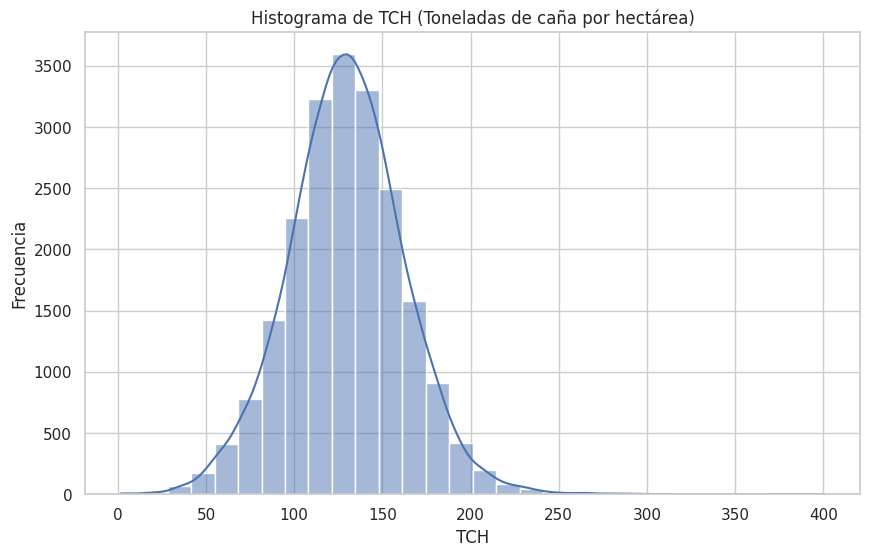

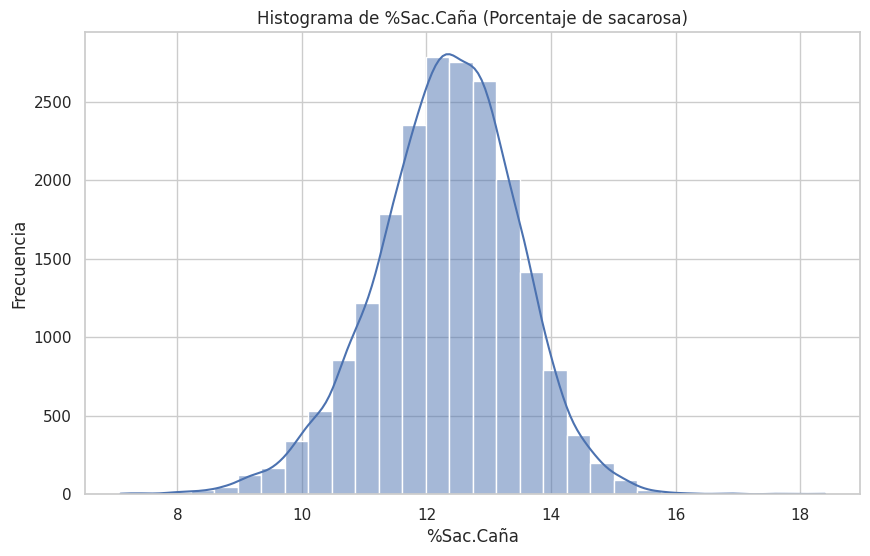

In [ ]:
# Histograma de TCH con KDE
plt.figure(figsize=(10, 6))
sns.histplot(df_hist['TCH'], bins=30, kde=True)
plt.title('Histograma de TCH (Toneladas de caña por hectárea)')
plt.xlabel('TCH')
plt.ylabel('Frecuencia')
plt.show()

# Histograma de %Sac.Caña con KDE
plt.figure(figsize=(10, 6))
sns.histplot(df_hist['%Sac.Caña'], bins=30, kde=True)
plt.title('Histograma de %Sac.Caña (Porcentaje de sacarosa)')
plt.xlabel('%Sac.Caña')
plt.ylabel('Frecuencia')
plt.show()

*Se observa un buen comportamiento (aparentemente normal) de las variables dependientes del estudio*

### 1.6 Análisis Multivariado

Se exploran las relaciones entre variables numéricas mediante gráficos de dispersión (pairplot) y matrices de correlación (métodos Pearson, Spearman y Kendall). Esto permite identificar tendencias y correlaciones entre variables como **TCH**, **%Sac.Caña**, **Edad Ult Cos**, entre otras.

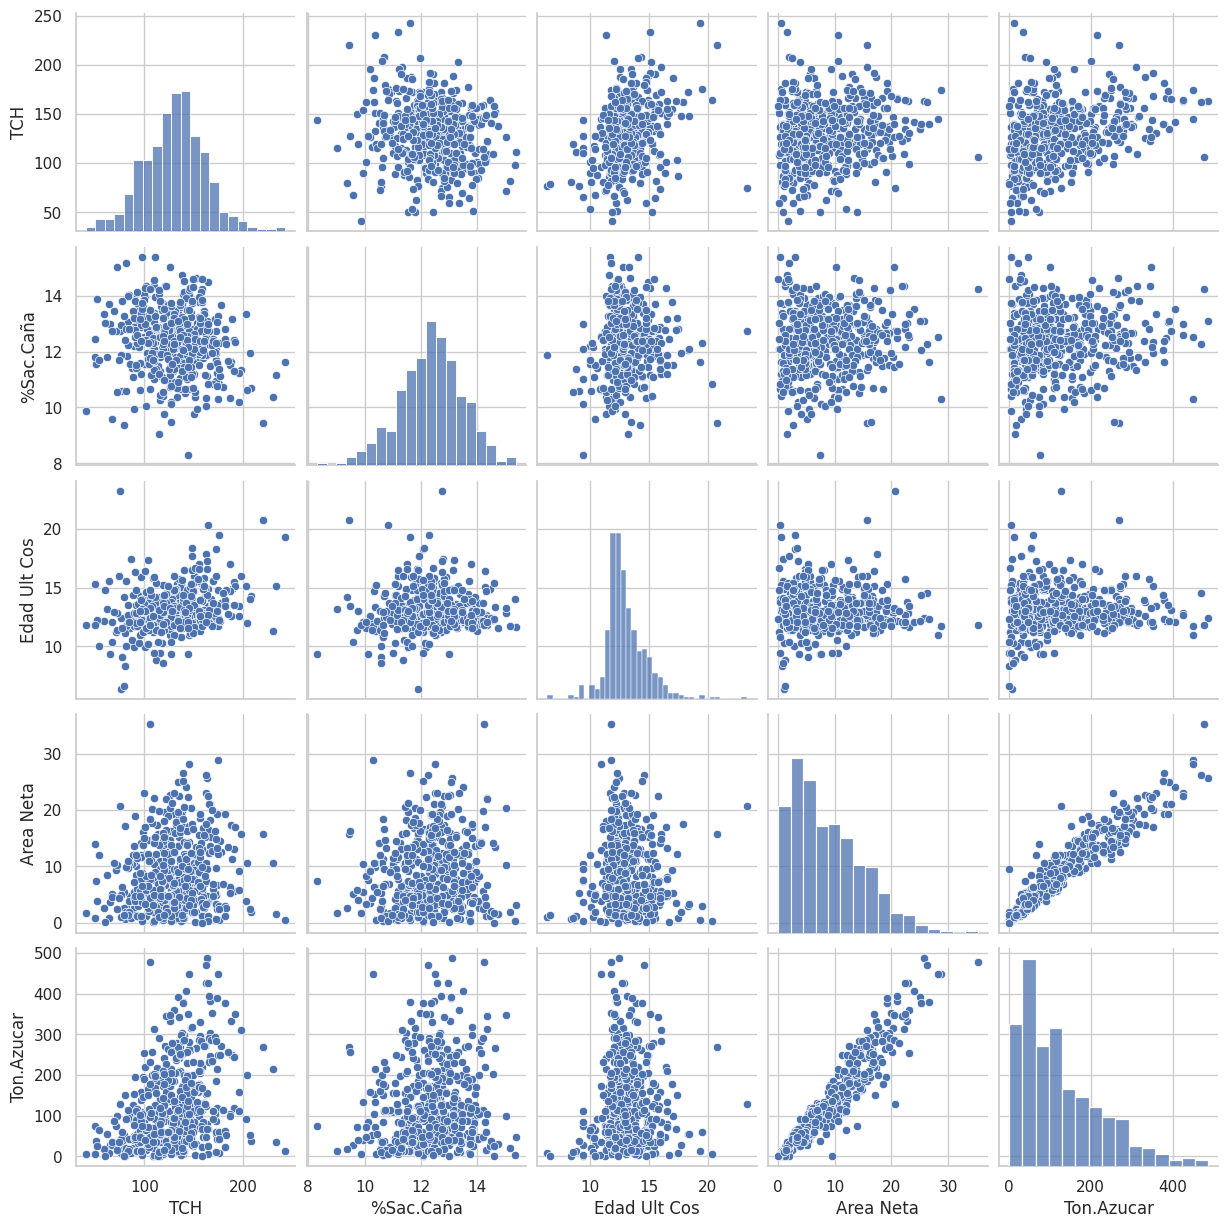

Correlación Pearson entre TCH y Edad Ult Cos: 0.2981659973900931
Correlación Pearson entre TCH y %Sac.Caña: -0.16805993195701666


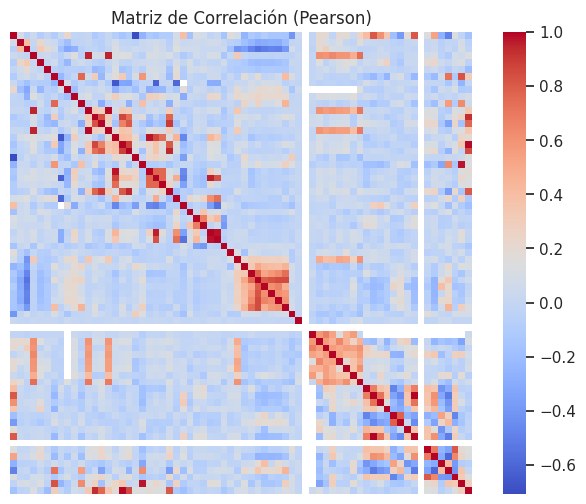

In [ ]:
# Seleccionar variables numéricas clave para el pairplot
vars_interes = ['TCH', '%Sac.Caña', 'Edad Ult Cos', 'Area Neta', 'Ton.Azucar']
sns.pairplot(df_hist.sample(500), vars=vars_interes, diag_kind='hist')
plt.show()

# Seleccionar solo columnas numéricas
df_hist_numeric = df_hist.select_dtypes(include=[np.number])

# Calcular las matrices de correlación usando únicamente los datos numéricos
corr_pearson = df_hist_numeric.corr(method='pearson')
corr_spearman = df_hist_numeric.corr(method='spearman')
corr_kendall = df_hist_numeric.corr(method='kendall')

# Mostrar algunos resultados
print("Correlación Pearson entre TCH y Edad Ult Cos:", corr_pearson.loc['TCH', 'Edad Ult Cos'])
print("Correlación Pearson entre TCH y %Sac.Caña:", corr_pearson.loc['TCH', '%Sac.Caña'])

# Visualización de la matriz de correlación de Pearson (sin etiquetas para simplificar la visualización)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_pearson, cmap='coolwarm', cbar=True, square=True, xticklabels=False, yticklabels=False)
plt.title('Matriz de Correlación (Pearson)')
plt.show()

### 1.5 Modelo de Regresión Lineal Múltiple

Se construyen modelos de regresión lineal para predecir dos variables objetivo: **TCH** (rendimiento) y **%Sac.Caña** (calidad). Se seleccionan variables predictoras relevantes, se realiza la transformación de variables categóricas mediante one-hot encoding y se escala la información numérica usando `StandardScaler`.

In [ ]:
# Eliminar registros con NaN en las variables objetivo
df_hist_clean = df_hist.dropna(subset=['TCH', '%Sac.Caña'])

# Definición de características predictoras
features_numericas = ['Edad Ult Cos', 'Dist Km', 'Dosis Madurante']
features_categoricas = ['Variedad', 'Tenencia', 'Zona']

# Separar variables predictoras y objetivos a partir del dataframe limpio
X = df_hist_clean[features_numericas + features_categoricas]
y_tch = df_hist_clean['TCH']          # Objetivo 1: rendimiento
y_sac = df_hist_clean['%Sac.Caña']      # Objetivo 2: sacarosa

# División de datos en entrenamiento y prueba
X_train, X_test, y_train_tch, y_test_tch = train_test_split(X, y_tch, test_size=0.2, random_state=42)
_, _, y_train_sac, y_test_sac = train_test_split(X, y_sac, test_size=0.2, random_state=42)

# Pipeline de preprocesamiento: Imputación de valores faltantes, escalado de variables numéricas
# y codificación one-hot para variables categóricas

preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),   # Imputa NaN con la media
        ('scaler', StandardScaler())
    ]), features_numericas),
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),   # Imputa NaN con el valor más frecuente
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), features_categoricas)
])

# Entrenamiento del modelo de regresión para TCH
model_tch = LinearRegression()
model_tch.fit(preprocessor.fit_transform(X_train), y_train_tch)

# Entrenamiento del modelo de regresión para %Sac.Caña
model_sac = LinearRegression()
model_sac.fit(preprocessor.transform(X_train), y_train_sac)


LinearRegression()

Para facilitar la interpretación, se integra el preprocesamiento y el modelo en un único pipeline, lo que permite examinar la influencia de cada variable (incluyendo las variables dummy generadas).

In [ ]:
# Integración en un Pipeline para TCH
pipeline_tch = Pipeline([('prep', preprocessor), ('linreg', LinearRegression())])
pipeline_tch.fit(X_train, y_train_tch)

# Extracción de coeficientes del modelo
coefs = pipeline_tch.named_steps['linreg'].coef_
features_expandidas = pipeline_tch.named_steps['prep'].get_feature_names_out()
coeficientes = pd.Series(coefs, index=features_expandidas).sort_values(key=abs, ascending=False)
display(coeficientes.head(10))

,0
cat__Variedad_CC01-1236,68.252174
cat__Zona_IC07,67.569375
cat__Variedad_CO421,59.317718
cat__Variedad_Q191,-47.793612
cat__Variedad_CC03-1029,-33.204231
cat__Variedad_CC06-791,30.442115
cat__Variedad_CC99-2461,-29.764101
cat__Zona_ip05,-27.465379
cat__Variedad_CC09-066,26.651807
cat__Variedad_CC09-449,26.539229


### 1.6 Diagnóstico de Supuestos del Modelo

Se evalúan los supuestos del modelo de regresión lineal: multicolinealidad (utilizando el Factor de Inflación de Varianza o VIF), normalidad de residuos (histograma, gráfico Q-Q y prueba de Shapiro-Wilk) y homocedasticidad (gráfico de residuos vs. valores predichos y prueba de Breusch-Pagan).

In [ ]:
# Actualizar el preprocesador para eliminar la dummy variable de referencia (drop='first')
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),   # Imputa NaN con la media
        ('scaler', StandardScaler())
    ]), features_numericas),
    ('cat', Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),   # Imputa NaN con el valor más frecuente
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))  # Elimina la primera columna dummy
    ]), features_categoricas)
])

# Ajustar el preprocesador con los datos de entrenamiento y obtener la matriz de diseño
X_design = preprocessor.fit_transform(X_train)
# Convertir a array denso en caso de que X_design sea una matriz dispersa
if hasattr(X_design, "toarray"):
    X_design = X_design.toarray()

# Extraer los nombres de las características resultantes del preprocesamiento
features_expandidas = preprocessor.get_feature_names_out()

vif = []
for i in range(X_design.shape[1]):
    vif.append(variance_inflation_factor(X_design, i))

# Crear un DataFrame para visualizar los VIF en formato de tabla
vif_df = pd.DataFrame({'Variable': features_expandidas, 'VIF': vif})
display(vif_df)

,Variable,VIF
0,num__Edad Ult Cos,1.040788
1,num__Dist Km,1.926295
2,num__Dosis Madurante,1.212226
3,cat__Variedad_CC00-3771,1.188559
4,cat__Variedad_CC00-3885,1.006060
...,...,...
65,cat__Zona_IP02,8.460227
66,cat__Zona_IP03,25.804111
67,cat__Zona_IP05,37.798342
68,cat__Zona_IP06,19.248754


* Siete variables tienen un VIF mayor a 10, por lo que pueden estar estrechamente correlacionadas con otras variables del estudio.

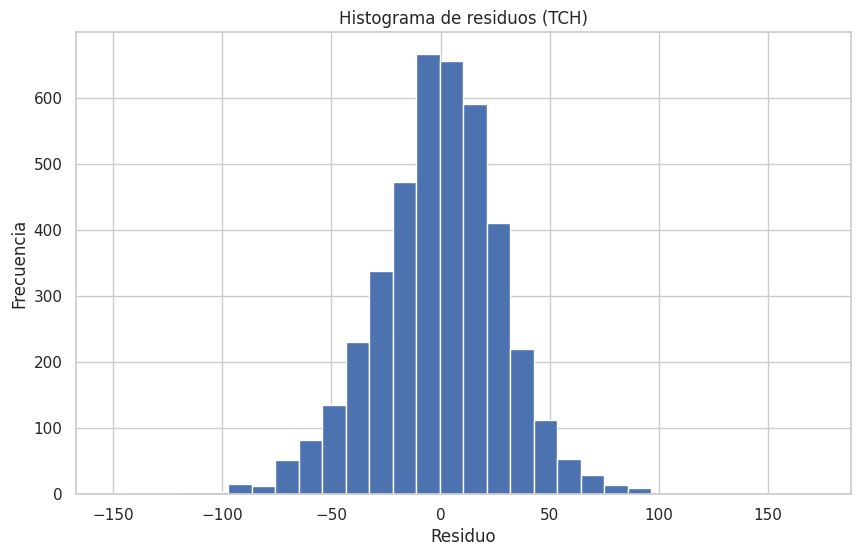

Shapiro-Wilk p-value: 1.0530698065319175e-16


In [ ]:
# Análisis de residuos para el modelo de TCH
y_pred_tch = pipeline_tch.predict(X_test)
resid_tch = y_test_tch - y_pred_tch

# Histograma de residuos
plt.figure(figsize=(10, 6))
plt.hist(resid_tch, bins=30)
plt.title('Histograma de residuos (TCH)')
plt.xlabel('Residuo')
plt.ylabel('Frecuencia')
plt.show()

# Prueba de normalidad Shapiro-Wilk
stat, p_value = stats.shapiro(resid_tch)
print(f"Shapiro-Wilk p-value: {p_value}")

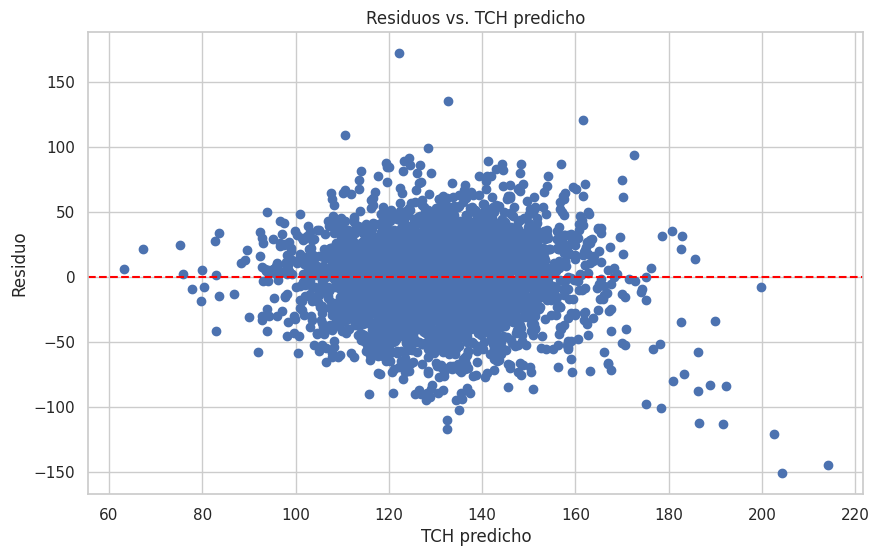

Breusch-Pagan p-value: 3.5200923704942255e-39


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [ ]:
# Evaluación de homocedasticidad: Gráfico de residuos vs. predicciones
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_tch, resid_tch)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuos vs. TCH predicho')
plt.xlabel('TCH predicho')
plt.ylabel('Residuo')
plt.show()

# Transformar X_test y convertir a matriz densa
X_test_trans = preprocessor.transform(X_test)
if hasattr(X_test_trans, "toarray"):
    X_test_trans = X_test_trans.toarray()

# Agregar una constante a X_test
X_test_const = sm.add_constant(X_test_trans)

# Prueba de Breusch-Pagan
bp_test = sm.stats.diagnostic.het_breuschpagan(resid_tch, X_test_const)
print(f"Breusch-Pagan p-value: {bp_test[3]}")


### 1.7 Validación Cruzada y Evaluación del Modelo

Se utiliza validación cruzada (K-Fold con 5 particiones) para estimar el desempeño del modelo y prevenir sobreajuste. Se calculan métricas como R², RMSE y MAE.

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluación del modelo de TCH usando R², RMSE y MAE
scores_r2 = cross_val_score(pipeline_tch, X, y_tch, cv=cv, scoring='r2')
scores_rmse = cross_val_score(pipeline_tch, X, y_tch, cv=cv, scoring='neg_root_mean_squared_error')
scores_mae = cross_val_score(pipeline_tch, X, y_tch, cv=cv, scoring='neg_mean_absolute_error')

print(f"R² por fold: {scores_r2}")
print(f"RMSE por fold: {-scores_rmse}")
print(f"MAE por fold: {-scores_mae}")
print(f"R² promedio: {scores_r2.mean()}")

R² por fold: [0.20634044 0.22186192 0.20723547 0.21368937 0.19445869]
RMSE por fold: [29.19293403 28.55644428 28.9108889  28.56692728 29.23569187]
MAE por fold: [22.37141428 21.96806491 22.11226653 22.12105975 22.34264233]
R² promedio: 0.20871717854388883


## Parte 2: Modelo de Clasificación (Categorías de Rendimiento y Calidad)

Esta sección utiliza el dataset `BD_IPSA_1940.xlsx`, que contiene registros detallados para construir modelos de clasificación. Se busca clasificar los lotes en categorías **Alto, Medio o Bajo** en términos de rendimiento (TCH) y contenido de azúcar (%Sac.Caña).

### 2.1 Generación de Etiquetas (Alto/Medio/Bajo)

In [ ]:
# Cargar el dataset detallado
df_ipsa = pd.read_excel('BD_IPSA_1940.xlsx', sheet_name=0)
display(df_ipsa.columns.tolist())
display(df_ipsa.head(5))

import numpy as np

# Calcular percentiles 33 y 66 para TCH y sacarosa
tch_low = np.percentile(df_ipsa['TCH'], 33)
tch_high = np.percentile(df_ipsa['TCH'], 66)
sac_low = np.percentile(df_ipsa['sacarosa'], 33)
sac_high = np.percentile(df_ipsa['sacarosa'], 66)
print(f"Umbrales TCH: {tch_low}, {tch_high}")
print(f"Umbrales Sacarosa: {sac_low}, {sac_high}")

# Crear etiquetas categóricas basadas en los percentiles
df_ipsa['TCH_cat'] = pd.cut(df_ipsa['TCH'],
                            bins=[-np.inf, tch_low, tch_high, np.inf],
                            labels=['Bajo','Medio','Alto'])
df_ipsa['Sac_cat'] = pd.cut(df_ipsa['sacarosa'],
                            bins=[-np.inf, sac_low, sac_high, np.inf],
                            labels=['Bajo','Medio','Alto'])
display(df_ipsa[['TCH', 'TCH_cat', 'sacarosa', 'Sac_cat']].head(5))

['Unnamed: 0',
 'NOME',
 'FAZ',
 'TAL',
 'tipocorte',
 'variedad',
 'madurada',
 'producto',
 'dosismad',
 'semsmad',
 'edad',
 'cortes',
 'me',
 'vejez',
 'sacarosa',
 'mes',
 'periodo',
 'TCH',
 'lluvias',
 'grupo_tenencia',
 'pct_diatrea']

,Unnamed: 0,NOME,FAZ,TAL,tipocorte,variedad,madurada,producto,dosismad,semsmad,...,cortes,me,vejez,sacarosa,mes,periodo,TCH,lluvias,grupo_tenencia,pct_diatrea
0,11,AMAIME SILCA,81291,40,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,8.3,...,4,12.7,2.4,14.0,12,202012,112,137,3,6.2
1,12,AMAIME SILCA,81291,41,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,6.3,...,2,7.8,2.3,13.0,3,201903,157,0,3,3.5
2,13,AMAIME SILCA,81291,41,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.6,7.9,...,3,8.8,1.8,13.3,3,202003,167,68,3,4.3
3,15,AMAIME SILCA,81291,43,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.8,6.6,...,1,6.1,2.5,13.4,3,201903,156,0,3,3.5
4,16,AMAIME SILCA,81291,43,Mecanizado Verde,CC01-1940,SI,BONUS 250 EC REGULADOR FISIOLÓGICO,0.6,8.1,...,2,7.9,2.1,14.0,3,202003,151,68,3,4.3


Umbrales TCH: 132.38, 153.0
Umbrales Sacarosa: 12.4, 13.1


,TCH,TCH_cat,sacarosa,Sac_cat
0,112,Bajo,14.0,Alto
1,157,Alto,13.0,Medio
2,167,Alto,13.3,Alto
3,156,Alto,13.4,Alto
4,151,Medio,14.0,Alto


### 2.2 Preparación de Datos para Clasificación

Se seleccionan las características predictoras y se procede a limpiar y preprocesar los datos. Se aplica escalado a las variables numéricas y codificación one-hot a las variables categóricas. Finalmente, se divide el dataset en conjuntos de entrenamiento y prueba, manteniendo la estratificación.

In [ ]:
# Seleccionar columnas relevantes para la clasificación
features = ['tipocorte', 'variedad', 'madurada', 'edad', 'cortes', 'dosismad',
            'semsmad', 'lluvias', 'mes', 'grupo_tenencia', 'pct_diatrea']

# Eliminar registros con valores nulos en características o etiquetas
df_clf = df_ipsa.dropna(subset=features + ['TCH_cat'])
X_clf = df_clf[features]
y_clf = df_clf['TCH_cat']  # Clasificación del rendimiento

# División de datos en entrenamiento y prueba (con estratificación)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clf, y_clf, stratify=y_clf, test_size=0.2, random_state=42)

# Pipeline de preprocesamiento para clasificación
preprocessor_clf = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['edad','cortes','dosismad','semsmad','lluvias','pct_diatrea','mes']),
    ('cat', OneHotEncoder(handle_unknown='ignore'), ['tipocorte','variedad','madurada','grupo_tenencia'])
])

### 2.3 Modelos de Clasificación

Se entrenan dos tipos de modelos para la tarea de clasificación multiclase (tres categorías):

- **k-Nearest Neighbors (KNN):** Con k=5.
- **Regresión Logística:** Se entrena utilizando regularización L2 (por defecto) y L1 (con `penalty='l1'` y solver `saga`).

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Pipeline para KNN
knn_pipeline = Pipeline([('prep', preprocessor_clf),
                         ('knn', KNeighborsClassifier(n_neighbors=5))])
knn_pipeline.fit(X_train_c, y_train_c)

# Pipelines para Regresión Logística con regularización L2 y L1
logregL2_pipeline = Pipeline([('prep', preprocessor_clf),
                              ('logreg', LogisticRegression(penalty='l2', C=1.0,
                                                            solver='saga', max_iter=1000))])
logregL1_pipeline = Pipeline([('prep', preprocessor_clf),
                              ('logreg', LogisticRegression(penalty='l1', C=1.0,
                                                            solver='saga', max_iter=1000))])

logregL2_pipeline.fit(X_train_c, y_train_c)
logregL1_pipeline.fit(X_train_c, y_train_c)

# Inspeccionar la cantidad de coeficientes no nulos en cada modelo
coef_l2 = logregL2_pipeline.named_steps['logreg'].coef_
coef_l1 = logregL1_pipeline.named_steps['logreg'].coef_
print("Número de coeficientes no nulos (L2):", np.count_nonzero(coef_l2))
print("Número de coeficientes no nulos (L1):", np.count_nonzero(coef_l1))

Número de coeficientes no nulos (L2): 39
Número de coeficientes no nulos (L1): 17


### 2.4 Validación Cruzada Estratificada

Se evalúan los modelos de clasificación mediante validación cruzada estratificada (5 particiones) para preservar la proporción de clases en cada fold. Se calcula la exactitud (accuracy) de cada modelo.

In [ ]:
cv_strat = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {
    "KNN": knn_pipeline,
    "Logistic L2": logregL2_pipeline,
    "Logistic L1": logregL1_pipeline
}

for name, model in models.items():
    scores = cross_val_score(model, X_clf, y_clf, cv=cv_strat, scoring='accuracy')
    print(f"{name} Accuracy (5-fold CV): {scores.mean():.3f}")

KNN Accuracy (5-fold CV): 0.446
Logistic L2 Accuracy (5-fold CV): 0.447
Logistic L1 Accuracy (5-fold CV): 0.447


### 2.5 Evaluación de los Modelos de Clasificación

En esta sección se obtienen las predicciones en el conjunto de prueba y se calculan las métricas de evaluación, incluyendo la matriz de confusión, el reporte de clasificación (precision, recall, F1-score) y el coeficiente Kappa de Cohen.

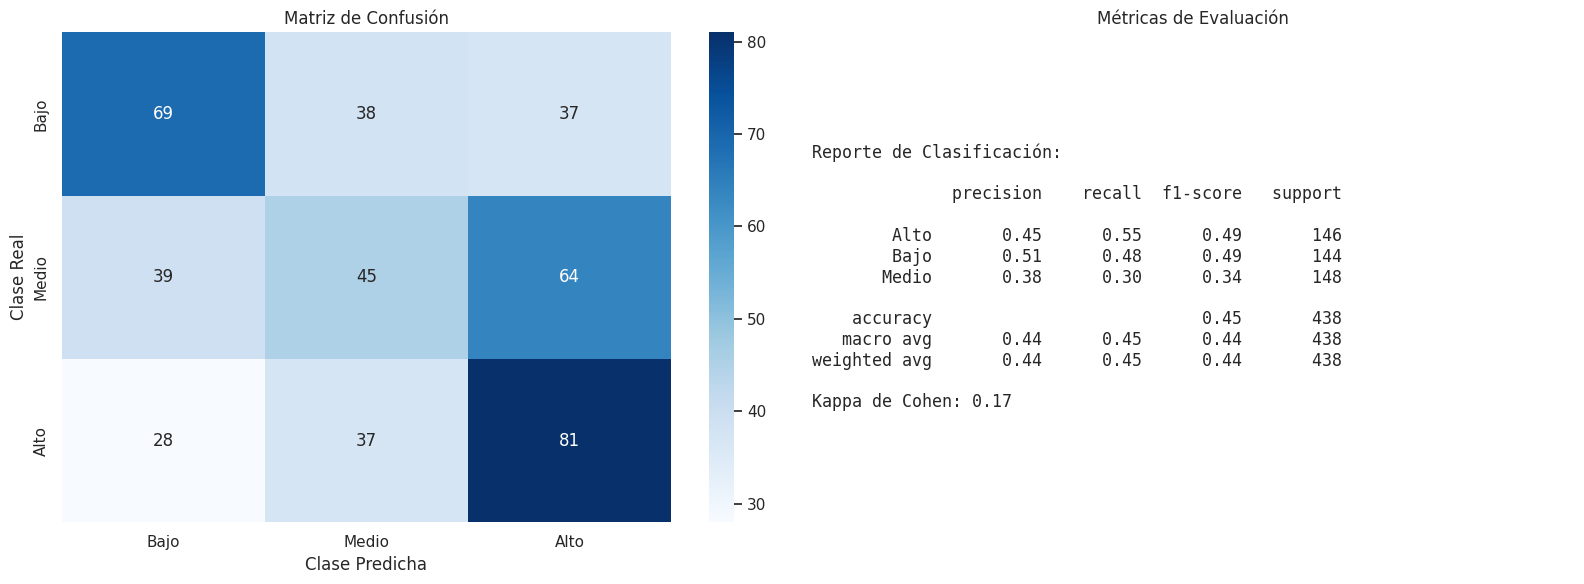

In [ ]:
# Predicción y evaluación del modelo KNN en el conjunto de prueba
y_pred_knn = knn_pipeline.predict(X_test_c)

# Calcular la matriz de confusión
cm = confusion_matrix(y_test_c, y_pred_knn, labels=["Bajo", "Medio", "Alto"])

# Crear figura con dos subplots: uno para la matriz y otro para las métricas
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Visualización de la matriz de confusión usando seaborn heatmap
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0],
            xticklabels=["Bajo", "Medio", "Alto"],
            yticklabels=["Bajo", "Medio", "Alto"])
ax[0].set_title("Matriz de Confusión")
ax[0].set_xlabel("Clase Predicha")
ax[0].set_ylabel("Clase Real")

# Generar el reporte de clasificación y calcular el coeficiente Kappa de Cohen
report = classification_report(y_test_c, y_pred_knn, digits=2)
kappa = cohen_kappa_score(y_test_c, y_pred_knn)

# Combinar las métricas en un único string
report_text = f"Reporte de Clasificación:\n\n{report}\nKappa de Cohen: {kappa:.2f}"

# Visualización de las métricas en el segundo subplot
ax[1].axis('off')  # Ocultar ejes para el texto
ax[1].text(0, 0.5, report_text, fontsize=12, va='center', fontfamily='monospace')
ax[1].set_title("Métricas de Evaluación")

plt.tight_layout()
plt.show()


Es probable que la predicción de niveles de sacarosa sea igual o más desafiante que la de TCH, porque el % de azúcar puede verse influido por factores sutiles. Aun así, podríamos encontrar que los modelos aciertan un porcentaje similar (40-50%). Si, por ejemplo, la clase "Alto" de sacarosa es muy claramente asociada a ciertos meses de cosecha (quizá cosechas en tiempos secos tienen más sacarosa), el modelo podría captar eso y tener mejor precisión en "Alto". Por brevedad, omitimos mostrar todo el código repetitivo para %Sac.Caña, pero los pasos son los mismos: definición de etiquetas, entrenamiento de modelos, validación cruzada y cálculo de métricas (accuracy, precision, recall, F1, kappa).

### 2.6 Clasificación de %Sac.Caña (Calidad de Azúcar)

Se sigue un procedimiento análogo para la variable de porcentaje de sacarosa. Se genera la etiqueta `Sac_cat` a partir de los percentiles y se entrenan modelos de clasificación para predecir dicha categoría. Por brevedad, se omite la repetición del código, ya que los pasos son equivalentes a los descritos para **TCH_cat**.

## Conclusiones

- Se desarrolló un modelo de regresión múltiple capaz de predecir el rendimiento (**TCH**) y la calidad (**%Sac.Caña**) de la caña de azúcar, alcanzando una capacidad explicativa moderada. La fase de limpieza de datos y el análisis exploratorio fueron fundamentales para detectar valores nulos, outliers y multicolinealidad, lo que aseguró la validez del modelo.

- Para la clasificación en categorías de rendimiento y calidad, los modelos de KNN y regresión logística lograron diferenciar parcialmente entre los niveles Alto, Medio y Bajo. Aunque la exactitud (~45-50%) es limitada, estos resultados evidencian la complejidad inherente a la separación de clases con los predictores disponibles.

- Este Notebook integra visualizaciones claras (histogramas, mapas de calor, matrices de confusión) y documentación detallada en cada sección, sentando las bases para futuros refinamientos, como la incorporación de datos adicionales o la prueba de algoritmos más complejos.